### ISC Within Languages

#### Import Modules

In [2]:
import pickle 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys, os, nilearn
sys.path.append("..")
from lpp_utils import *
from nilearn import datasets, plotting
from statsmodels.stats.multitest import multipletests
from scipy.stats import norm, pearsonr, zscore


import seaborn as sns
from nltools.stats import isc, isfc, threshold, fdr
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from tqdm import tqdm
from nilearn.connectome import sym_matrix_to_vec



In [75]:
path = "../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppEN-run-01.npy"

parcellation_networks = '../../data_lpp/fmri_data/other/shen_subcort_parcellation_networklabels.csv'
df_labels = pd.read_csv(parcellation_networks)
df_labels

# Sort df_labels by network_label
df_labels_sorted = df_labels.sort_values('Network');
df_labels_sorted['Node']-1

label_changes = np.diff(df_labels_sorted['Network'])
bounds = list(np.where(label_changes != 0)[0] - 0.5)
bounds

[27.5, 61.5, 81.5, 171.5, 221.5, 239.5, 248.5, 266.5]

#### Load data, perform basic ISFC


In [76]:
def plot_fc_isfc(input_data_path, suptitle):
    
    ts_data = np.load(path)
    for current_data_index in range(ts_data.shape[2]):
        #print(current_data_index)
        df_data = pd.DataFrame(ts_data[:,:, current_data_index].T);
        df_data.index = range(1, 294)  # set index to match 'number' in df_labels
           
        # Reindex df_data based on the sorted order
        df_data_sorted = df_data.reindex(df_labels_sorted['Node']);
            
        # Reset index for both DataFrames
        df_labels_sorted.reset_index(drop=True, inplace=True);
        df_data_sorted.reset_index(drop=True, inplace=True);
        
        ts_data[:,:, current_data_index] = df_data_sorted.values.T;

    print(ts_data.shape);
    
    
    # ISFC
    ts_data_list = [ts_data[:, :, i] for i in range(ts_data.shape[2])]
    len(ts_data_list);
    
    isfc_output = isfc(ts_data_list)
    
    
    # intra-subject connectivity
    curr_conn = []
    for curr in ts_data_list:
        curr_conn.append(np.corrcoef(curr.T))
    
    m_curr_conn = np.mean(np.asarray(curr_conn), axis = 0)
    
    
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    
    sns.heatmap(m_curr_conn, vmin=-1, vmax=1, square=True, cmap='RdBu_r', xticklabels=False, yticklabels=False, cbar=False)
    for b in bounds:
      plt.axvline(x=b,color='red');
      plt.axhline(y=b,color='red');
    plt.title('Connectivity (intra)', fontsize=14)
    plt.xlabel('ROI', fontsize=12)
    plt.ylabel('ROI', fontsize=12)
    
    plt.subplot(1,2,2)
    
    sns.heatmap(np.array(isfc_output).mean(axis=0), vmin=-0.5, vmax=0.5, square=True, cmap='RdBu_r', xticklabels=False, yticklabels=False, cbar=False)
    for b in bounds:
      plt.axvline(x=b,color='red');
      plt.axhline(y=b,color='red');
    plt.title('ISFC', fontsize=14)
    plt.xlabel('ROI', fontsize=12)
    plt.ylabel('ROI', fontsize=12)
    
    plt.suptitle(suptitle, fontsize = 18)

(282, 293, 50)
(282, 293, 50)
(282, 293, 50)


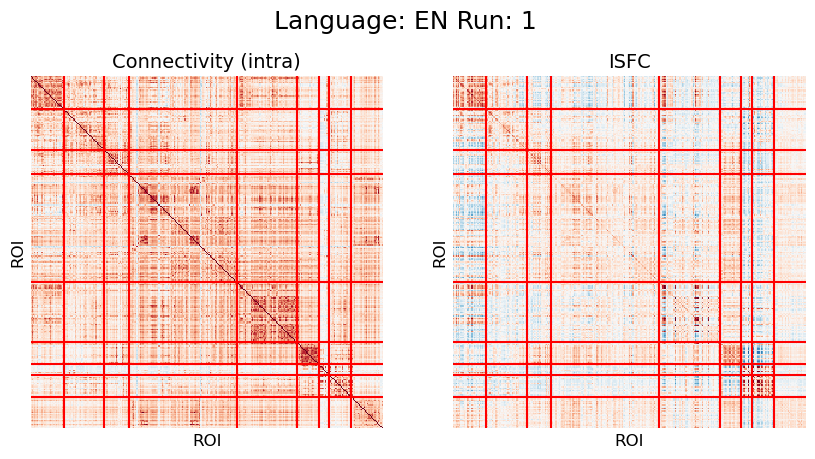

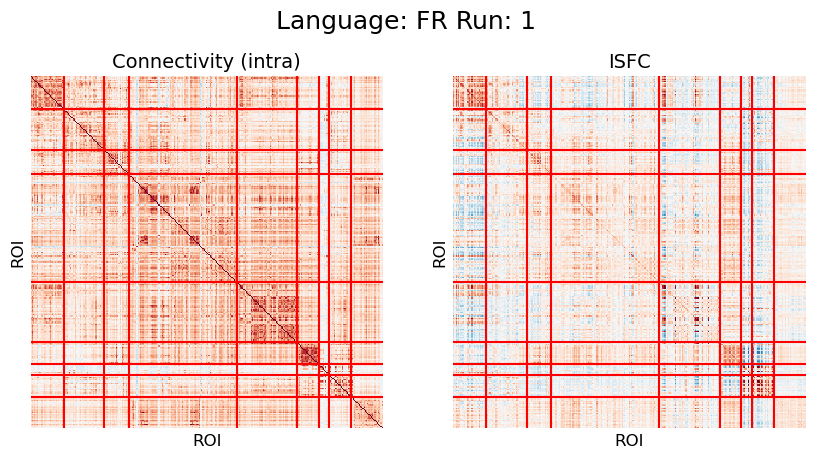

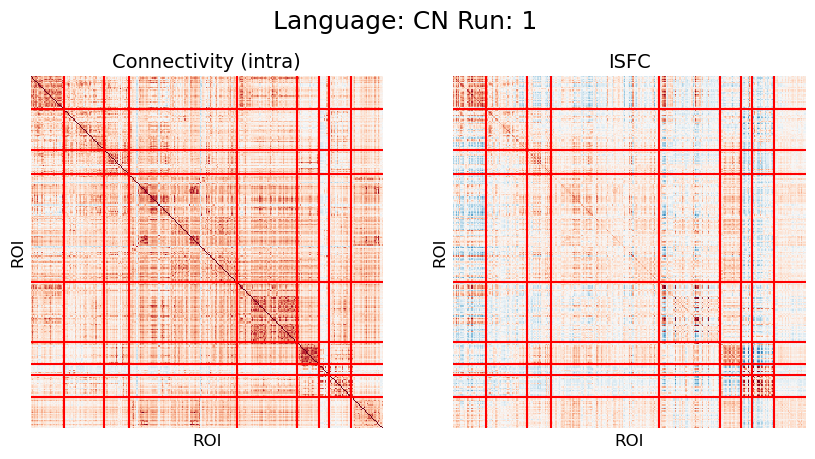

In [81]:
languages = ['EN', 'FR', 'CN']

for curr_run in range(1, 2):#9):
    for curr_lang in languages:
        curr_path =  '../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lpp' + curr_lang + '-run-0' + str(curr_run) + '.npy'
        curr_sup_tiltle = 'Language: ' + curr_lang + ' Run: ' + str(curr_run)
        plot_fc_isfc(curr_path, curr_sup_tiltle)

In [82]:
import warnings
warnings.filterwarnings("ignore")

../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppFR-run-01.npy
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppCN-run-01.npy
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppEN-run-01.npy
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppFR-run-02.npy
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppCN-run-02.npy
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppEN-run-02.npy
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppFR-run-03.npy
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppCN-run-03.npy
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppEN-run-03.npy
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppFR-run-04.npy
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppCN-run-04.npy
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppEN-run-04.npy
../.

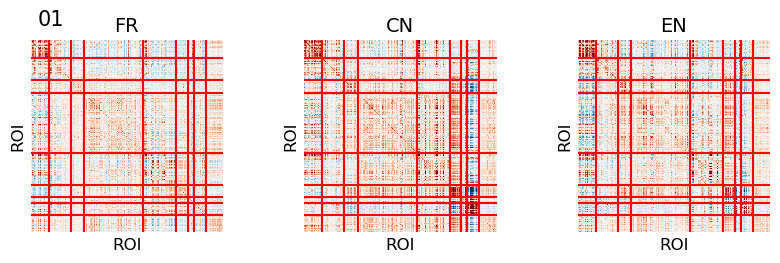

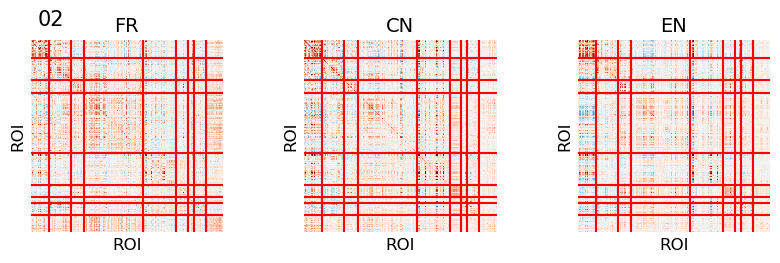

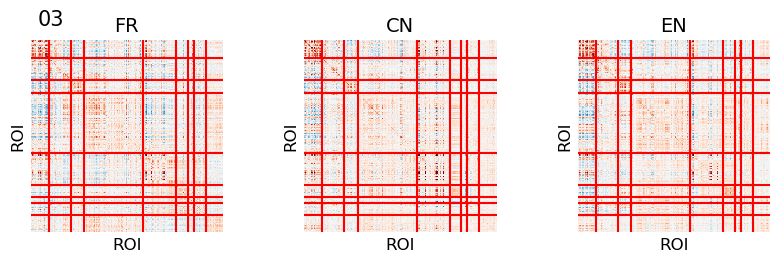

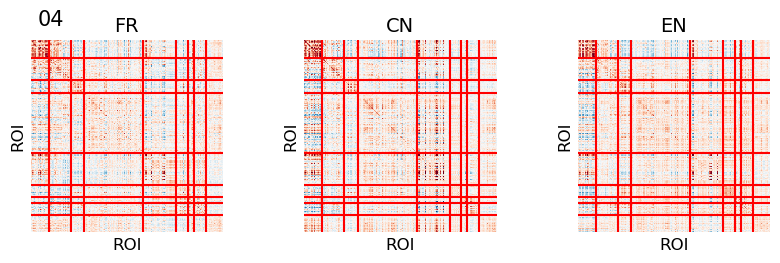

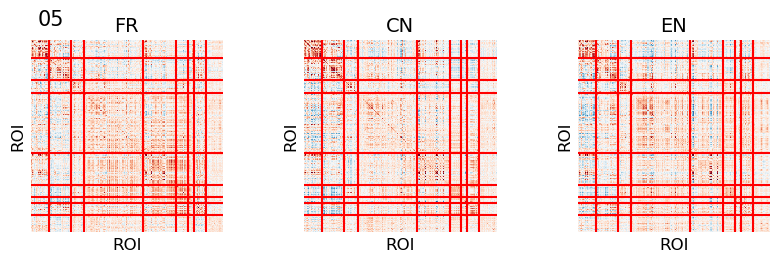

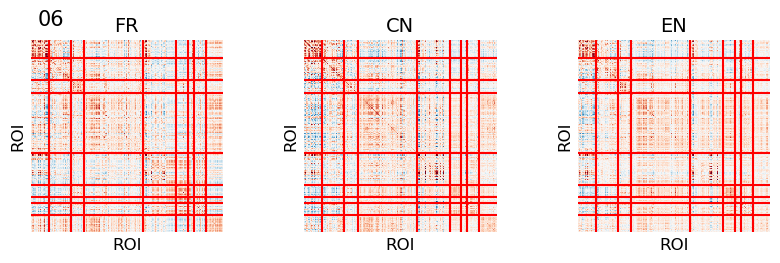

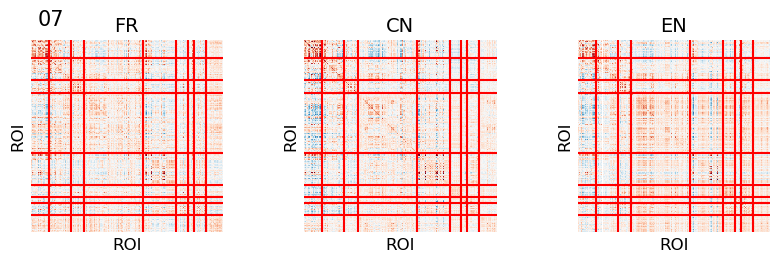

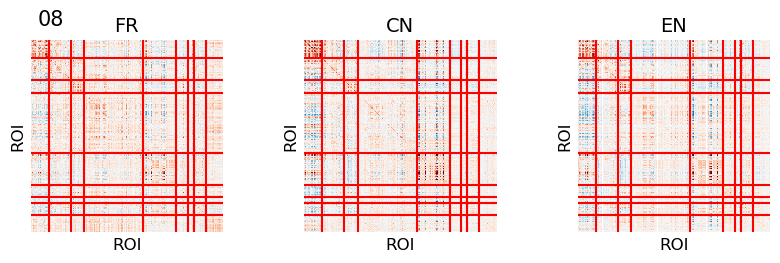

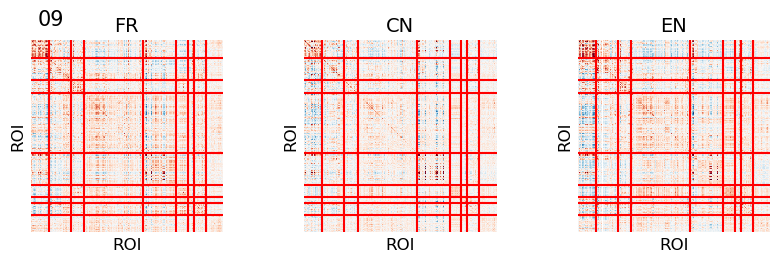

In [83]:
base_path =    "../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lpp"
languages = ['FR', 'CN', 'EN']
runs = ['01', '02', '03', '04','05', '06','07', '08','09']
isfc_vecs = []

for current_run in runs:
    plt.figure(figsize = (10,2.5))
    plt.suptitle(current_run, x=0.15, y=1, horizontalalignment='left', verticalalignment='top', fontsize = 15)

    for current_language_index in range(len(languages)):
        
        curr_lang = languages[current_language_index]
        path_to_load = base_path + curr_lang + '-run-' + current_run + '.npy'
        print(path_to_load)
        
        ts_data = np.load(path_to_load)
        for current_data_index in range(ts_data.shape[2]):
            #print(current_data_index)
            df_data = pd.DataFrame(ts_data[:,:, current_data_index].T);
            df_data.index = range(1, 294)  # set index to match 'number' in df_labels
               
            # Reindex df_data based on the sorted order
            df_data_sorted = df_data.reindex(df_labels_sorted['Node']);
                
            # Reset index for both DataFrames
            df_labels_sorted.reset_index(drop=True, inplace=True);
            df_data_sorted.reset_index(drop=True, inplace=True);
            
            ts_data[:,:, current_data_index] = df_data_sorted.values.T;
        
        ts_data_list = [ts_data[:, :, i] for i in range(ts_data.shape[2])]        
        isfc_output = isfc(ts_data_list)  
        m_isfc = np.array(isfc_output).mean(axis=0)
        lower_diagonal_vector = sym_matrix_to_vec(m_isfc, discard_diagonal=True)
        isfc_vecs.append(lower_diagonal_vector)
        
        plt.subplot(1,3,current_language_index+1)
        sns.heatmap(m_isfc, vmin=-0.35, vmax=0.35, square=True, cmap='RdBu_r', xticklabels=False, yticklabels=False, cbar=False)
        for b in bounds:
          plt.axvline(x=b,color='red');
          plt.axhline(y=b,color='red');
        plt.title(curr_lang, fontsize=14); plt.xlabel('ROI', fontsize=12); plt.ylabel('ROI', fontsize=12)
    
    #plt.show()
        


../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppFR-run-01.npy
(309, 293, 27)
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppCN-run-01.npy
(283, 293, 33)
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppEN-run-01.npy
(282, 293, 50)
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppFR-run-02.npy
(326, 293, 27)
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppCN-run-02.npy
(322, 293, 33)
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppEN-run-02.npy
(298, 293, 50)
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppFR-run-03.npy
(354, 293, 27)
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppCN-run-03.npy
(322, 293, 33)
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppEN-run-03.npy
(340, 293, 50)
../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppFR-run-04.npy
(315, 293, 27)
../../data_lpp/fmri_

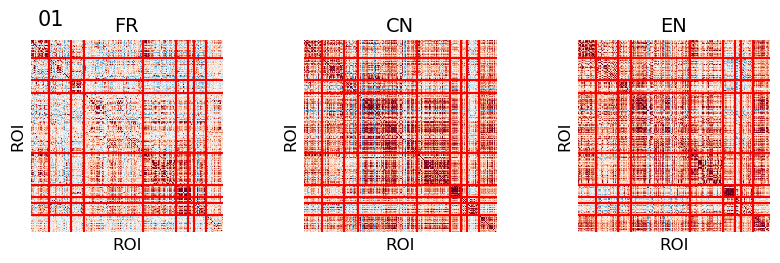

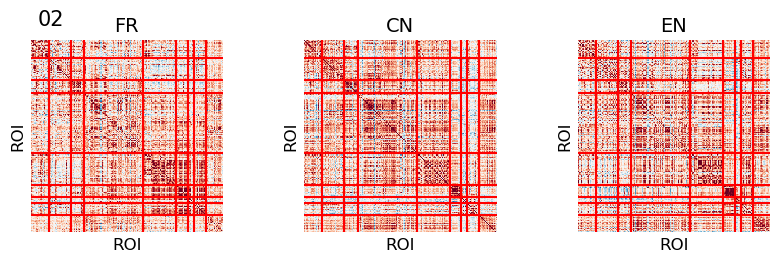

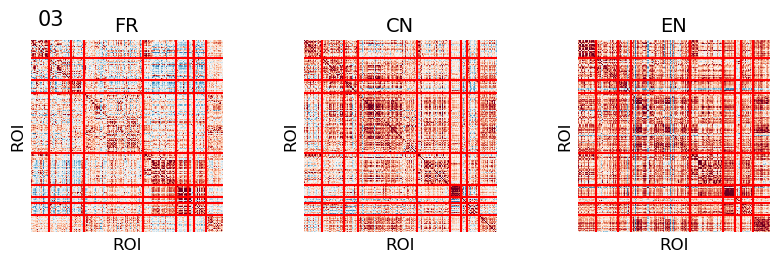

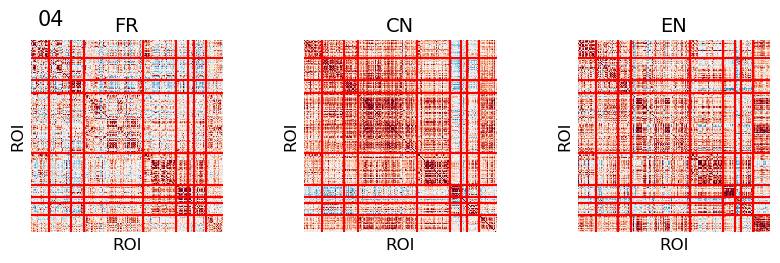

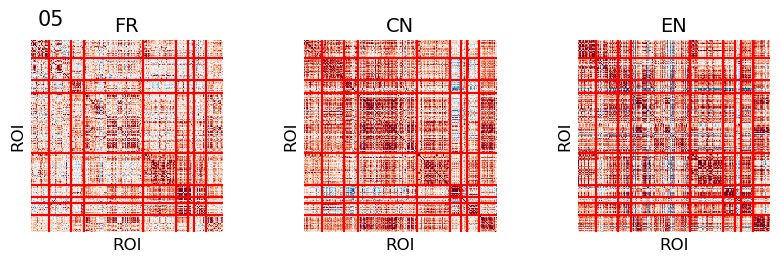

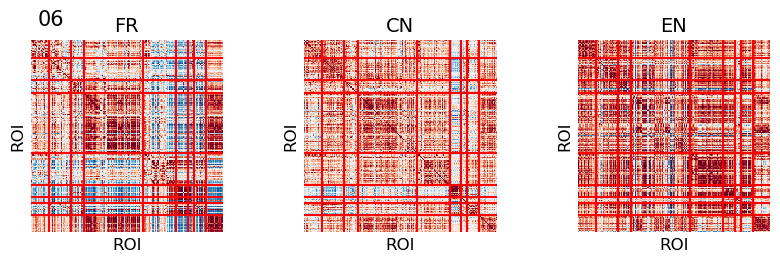

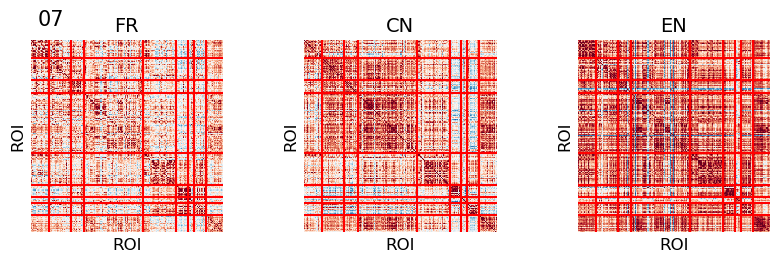

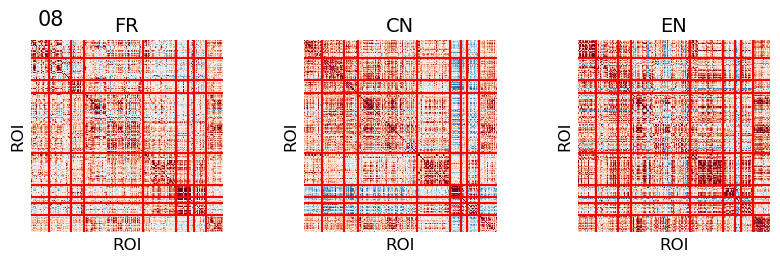

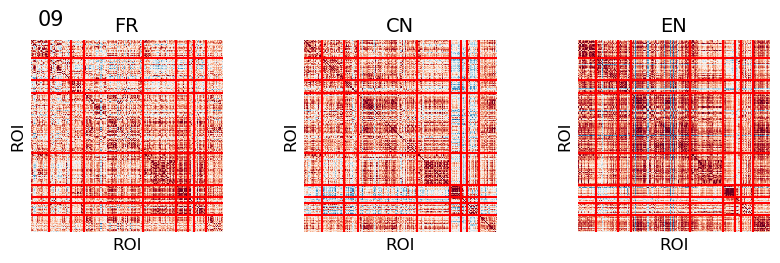

In [84]:
base_path =    "../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lpp"
languages = ['FR', 'CN', 'EN']
runs = ['01', '02', '03', '04','05', '06','07', '08','09']
conn_vecs = []


for current_run in runs:
    plt.figure(figsize = (10,2.5))
    plt.suptitle(current_run, x=0.15, y=1, horizontalalignment='left', verticalalignment='top', fontsize = 15)

    for current_language_index in range(len(languages)):
        
        curr_lang = languages[current_language_index]
        path_to_load = base_path + curr_lang + '-run-' + current_run + '.npy'
        print(path_to_load)
        
        ts_data = np.load(path_to_load)
        for current_data_index in range(ts_data.shape[2]):
            #print(current_data_index)
            df_data = pd.DataFrame(ts_data[:,:, current_data_index].T);
            df_data.index = range(1, 294)  # set index to match 'number' in df_labels
               
            # Reindex df_data based on the sorted order
            df_data_sorted = df_data.reindex(df_labels_sorted['Node']);
                
            # Reset index for both DataFrames
            df_labels_sorted.reset_index(drop=True, inplace=True);
            df_data_sorted.reset_index(drop=True, inplace=True);
            
            ts_data[:,:, current_data_index] = df_data_sorted.values.T;
        
        print(ts_data.shape)
        x,y,n_subjs = ts_data.shape
        connectivities = []
        for currs in range(n_subjs):
            curr_data = ts_data[:,:, currs]
            curr_conn = np.corrcoef(ts_data[:,:, 0].T)
            connectivities.append(curr_conn)
        m_conn = np.mean(np.stack(connectivities, axis = 0), axis = 0)
        
        lower_diagonal_vector = sym_matrix_to_vec(m_conn, discard_diagonal=True)
        conn_vecs.append(lower_diagonal_vector)
        
        plt.subplot(1,3,current_language_index+1)
        sns.heatmap(m_conn, vmin=-0.75, vmax=0.75, square=True, cmap='RdBu_r', xticklabels=False, yticklabels=False, cbar=False)
        for b in bounds:
          plt.axvline(x=b,color='red');
          plt.axhline(y=b,color='red');
        plt.title(curr_lang, fontsize=14); plt.xlabel('ROI', fontsize=12); plt.ylabel('ROI', fontsize=12)
    
    #plt.show()
        


In [85]:
base_path =    "../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lpp"
languages = ['FR', 'CN', 'EN']
runs = ['01', '02', '03', '04','05', '06','07', '08','09']
isfc_vecs = []

for current_language_index in range(len(languages)):
    for current_run in runs:
 
        curr_lang = languages[current_language_index]
        path_to_load = base_path + curr_lang + '-run-' + current_run + '.npy'
        
        ts_data = np.load(path_to_load)
        for current_data_index in range(ts_data.shape[2]):
            #print(current_data_index)
            df_data = pd.DataFrame(ts_data[:,:, current_data_index].T);
            df_data.index = range(1, 294)  # set index to match 'number' in df_labels
               
            # Reindex df_data based on the sorted order
            df_data_sorted = df_data.reindex(df_labels_sorted['Node']);
                
            # Reset index for both DataFrames
            df_labels_sorted.reset_index(drop=True, inplace=True);
            df_data_sorted.reset_index(drop=True, inplace=True);
            
            ts_data[:,:, current_data_index] = df_data_sorted.values.T;
        
        
        ts_data_list = [ts_data[:, :, i] for i in range(ts_data.shape[2])]        
        isfc_output = isfc(ts_data_list)  
        m_isfc = np.array(isfc_output).mean(axis=0)
        lower_diagonal_vector = sym_matrix_to_vec(m_isfc, discard_diagonal=True)
        isfc_vecs.append(lower_diagonal_vector)



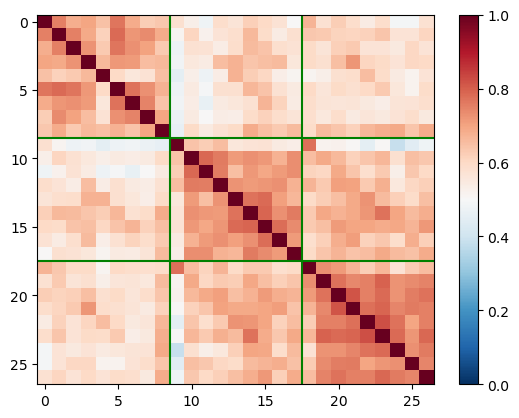

In [87]:
isfc_vecs = np.asarray(isfc_vecs)
isfc_vecs_cleaned = np.nan_to_num(isfc_vecs, nan=0.0)
corr_matrix = np.corrcoef(isfc_vecs_cleaned)

# Plot the correlation matrix
plt.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin = 0, vmax = 1)
b2 = [8.5, 17.5]
for b in b2:
      plt.axvline(x=b,color='green');
      plt.axhline(y=b,color='green');
plt.colorbar()
plt.show()

In [88]:
base_path =    "../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lpp"
languages = ['FR', 'CN', 'EN']
runs = ['01', '02', '03', '04','05', '06','07', '08','09']
conn_vecs = []

for current_language_index in range(len(languages)):
    for current_run in runs:
 
        curr_lang = languages[current_language_index]
        path_to_load = base_path + curr_lang + '-run-' + current_run + '.npy'
       
        ts_data = np.load(path_to_load)

        for current_data_index in range(ts_data.shape[2]):
            #print(current_data_index)
            df_data = pd.DataFrame(ts_data[:,:, current_data_index].T);
            df_data.index = range(1, 294)  # set index to match 'number' in df_labels
               
            # Reindex df_data based on the sorted order
            df_data_sorted = df_data.reindex(df_labels_sorted['Node']);
                
            # Reset index for both DataFrames
            df_labels_sorted.reset_index(drop=True, inplace=True);
            df_data_sorted.reset_index(drop=True, inplace=True);
            
            ts_data[:,:, current_data_index] = df_data_sorted.values.T;
        
        print(ts_data.shape)
        x,y,n_subjs = ts_data.shape
        connectivities = []
        for currs in range(n_subjs):
            curr_data = ts_data[:,:, currs]
            curr_conn = np.corrcoef(ts_data[:,:, 0].T)
            connectivities.append(curr_conn)
        m_conn = np.mean(np.stack(connectivities, axis = 0), axis = 0)
        
        lower_diagonal_vector = sym_matrix_to_vec(m_conn, discard_diagonal=True)
        conn_vecs.append(lower_diagonal_vector)



(309, 293, 27)
(326, 293, 27)
(354, 293, 27)
(315, 293, 27)
(293, 293, 27)
(378, 293, 27)
(332, 293, 27)
(294, 293, 27)
(336, 293, 27)
(283, 293, 33)
(322, 293, 33)
(322, 293, 33)
(307, 293, 33)
(293, 293, 33)
(392, 293, 33)
(364, 293, 33)
(293, 293, 33)
(401, 293, 33)
(282, 293, 50)
(298, 293, 50)
(340, 293, 50)
(303, 293, 50)
(265, 293, 50)
(343, 293, 50)
(325, 293, 50)
(292, 293, 50)
(368, 293, 50)


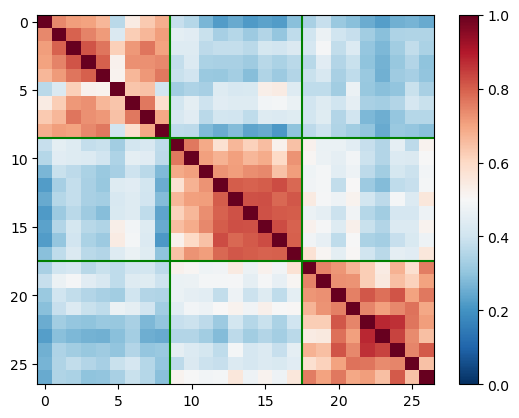

In [89]:
conn_vecs = np.asarray(conn_vecs)
conn_vecs_cleaned = np.nan_to_num(conn_vecs, nan=0.0)
corr_matrix = np.corrcoef(conn_vecs_cleaned)

# Plot the correlation matrix
plt.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin = 0, vmax = 1)
b2 = [8.5 ,17.5]
for b in b2:
      plt.axvline(x=b,color='green');
      plt.axhline(y=b,color='green');
plt.colorbar()
plt.show()

In [90]:
conn_vecs_cleaned.shape

(27, 42778)

In [91]:
isfc_vecs_cleaned.shape

(27, 42778)

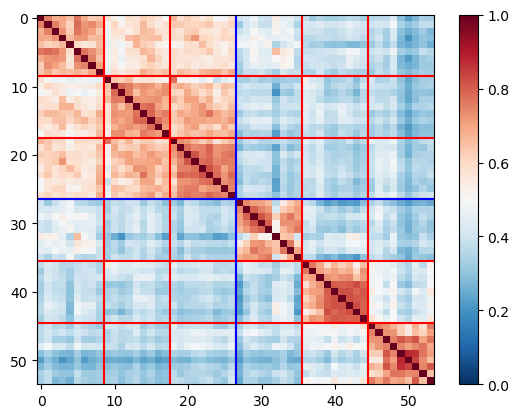

In [94]:
all_corr_matrix = np.corrcoef(np.vstack((isfc_vecs_cleaned, conn_vecs_cleaned)) )

plt.imshow(all_corr_matrix, cmap='RdBu_r', aspect='auto', vmin = 0, vmax = 1)
b2 = [8.5,17.5, 26.5, 35.5, 44.5]
for b in b2:
      plt.axvline(x=b,color='red');
      plt.axhline(y=b,color='red');

b3 = [26.5]
for b in b3:
      plt.axvline(x=b,color='blue');
      plt.axhline(y=b,color='blue');
    
plt.colorbar()
plt.show()

In [103]:
parc_file = '../../data_lpp/fmri_data/other/allcombined.nii'

coords, labels = nilearn.plotting.find_parcellation_cut_coords(parc_file, return_label_names = True)

In [132]:
number_to_color = {
    1: 'green',
    2: 'blue',
    3: 'red',
    4: 'yellow',
    5: 'purple',
    6: 'orange',
    7: 'pink',
    8: 'cyan',
    9: 'magenta'
}

# Mapping the numbers to colors
colors = [number_to_color[number] for number in list(df_labels.Network.values)]

['blue', 'yellow', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'blue', 'green', 'yellow', 'green', 'red', 'blue', 'yellow', 'green', 'blue', 'yellow', 'blue', 'yellow', 'blue', 'blue', 'purple', 'purple', 'purple', 'purple', 'purple', 'yellow', 'yellow', 'blue', 'blue', 'yellow', 'purple', 'purple', 'purple', 'yellow', 'purple', 'purple', 'purple', 'purple', 'cyan', 'orange', 'cyan', 'yellow', 'purple', 'purple', 'blue', 'blue', 'red', 'red', 'purple', 'green', 'green', 'green', 'blue', 'green', 'green', 'purple', 'cyan', 'purple', 'purple', 'purple', 'purple', 'green', 'green', 'cyan', 'cyan', 'orange', 'cyan', 'blue', 'cyan', 'orange', 'cyan', 'cyan', 'orange', 'pink', 'orange', 'pink', 'orange', 'orange', 'pink', 'orange', 'yellow', 'purple', 'red', 'red', 'orange', 'yellow', 'purple', 'red', 'yellow', 'purple', 'yellow', 'yellow', 'yellow', 'red', 'purple', 'orange', 'yellow', 'pink', 'yellow', 'pink', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'purple', 'yellow',

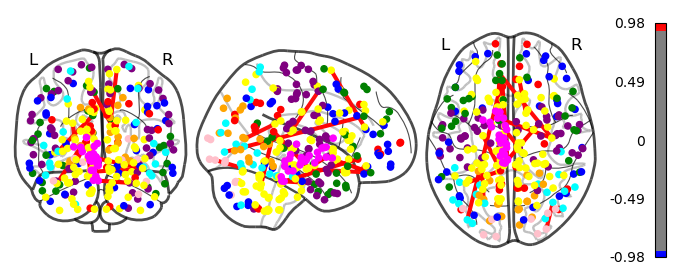

In [135]:
matrix = np.corrcoef(ts_data[:,:, 0].T)  # one example dataset to visualize connectivity network on brain

plotting.plot_connectome(
    matrix,
    coords,
    #title="correlation graph",
    node_size=20,
    node_color = colors, 
    edge_threshold = "99.97%",
    colorbar=True)

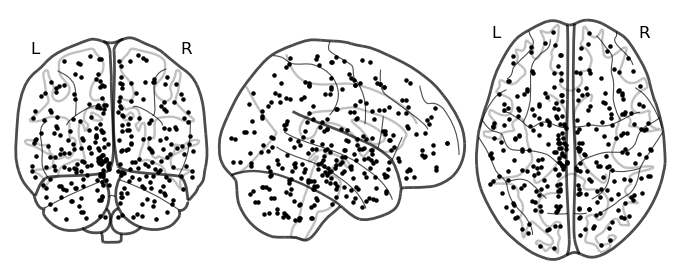

In [139]:
plotting.plot_connectome(
    matrix,
    coords,
    #title="correlation graph",
    node_size= 5,
    node_color = 'black', 
    edge_threshold = 2,
    #colorbar=True
)